In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model 
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [7]:
data = pd.read_csv('data/iris.csv')
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [9]:
iris_class = {'setosa':0, 'versicolor':1, 'virginica':2}
data['species_num'] = [iris_class[i] for i in data.species]
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


In [10]:
df_train = data.sample(frac=0.7, random_state=0)
df_valid = data.drop(df_train.index)

In [11]:
X_train = df_train.drop(['petal_length', 'species', 'species_num'], axis = 1)
X_valid = df_valid.drop(['petal_length', 'species', 'species_num'], axis = 1)

y_train = df_train['petal_length']
y_valid = df_valid['petal_length']

z_train = df_train['species_num']
z_valid = df_valid['species_num']

### **Build Model**

In [21]:
inputs = Input(shape=(3,), name = 'input')
# x = Dense(3, activation="relu", name='31')(inputs)
# x = Dense(3, activation="relu", name='32')(x)

# do ít mẫu quá nên có thể xảy ra underfitting => mở rộng layers theo chiều rộng
x = Dense(16, activation="relu", name='16')(inputs)
x = Dense(32, activation="relu", name='32')(x)

output1 = Dense(1, name = 'continuous_out')(x)
output2 = Dense(3, activation="softmax", name = 'categorical_out')(x)




In [22]:
model = Model(inputs=inputs, outputs=[output1, output2])
model.compile(optimizer="adam", loss={
    'continuous_out': 'mse',
    'categorical_out': 'sparse_categorical_crossentropy'
})


In [23]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 3)]          0           []                               
                                                                                                  
 16 (Dense)                     (None, 16)           64          ['input[0][0]']                  
                                                                                                  
 32 (Dense)                     (None, 32)           544         ['16[0][0]']                     
                                                                                                  
 continuous_out (Dense)         (None, 1)            33          ['32[0][0]']                     
                                                                                            

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience=20, 
    restore_best_weights = True
)

In [27]:
history = model.fit(
    X_train,
    {'continuous_out': y_train, 'categorical_out': z_train},
    validation_data=(X_valid, 
                     {'continuous_out': y_valid, 'categorical_out': z_valid}),
    batch_size=32,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0 # turn off training log
)


In [28]:
history_df = pd.DataFrame(history.history)
history_df

,loss,continuous_out_loss,categorical_out_loss,val_loss,val_continuous_out_loss,val_categorical_out_loss
0,20.103045,18.686022,1.417023,17.263697,15.717071,1.546625
1,17.476725,16.120510,1.356214,14.997299,13.519971,1.477329
2,15.195518,13.878379,1.317140,13.112410,11.685015,1.427395
3,13.329265,12.037242,1.292023,11.425912,10.030187,1.395725
4,11.650152,10.373554,1.276599,9.883697,8.515158,1.368538
...,...,...,...,...,...,...
195,0.373393,0.076997,0.296396,0.354628,0.083750,0.270879
196,0.370755,0.076948,0.293807,0.348205,0.081561,0.266645
197,0.369669,0.077566,0.292104,0.346099,0.082021,0.264079
198,0.369044,0.078394,0.290649,0.344322,0.081443,0.262879


Minimum loss: 0.36557963490486145


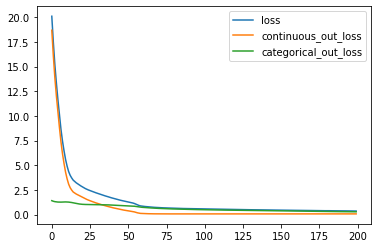

In [32]:
history_df.loc[:, ['loss', 'continuous_out_loss', 'categorical_out_loss']].plot()
print("Minimum loss: {}".format(history_df['loss'].min()))


In [34]:
# regression output
y_z_hat_valid = model.predict(X_valid)
y_z_hat_valid[0][:5]

array([[-1.7014248],
       [-1.528707 ],
       [-1.9438798],
       [-1.808325 ],
       [-1.7710392]], dtype=float32)

In [35]:
# classification output
y_z_hat_valid[1][:5]

array([[0.3805815 , 0.58542943, 0.03398911],
       [0.38741216, 0.5746334 , 0.03795451],
       [0.37425348, 0.6018194 , 0.02392718],
       [0.3856256 , 0.57984626, 0.03452817],
       [0.3694414 , 0.5970471 , 0.0335115 ]], dtype=float32)

In [36]:
'''
[0.3805815 , 0.58542943, 0.03398911] tương ứng với xác suất hoa đó thuộc loại nào
'''
sum([0.3805815 , 0.58542943, 0.03398911])

1.00000004

In [40]:
# tìm index của giá trị p lớn nhất mỗi mẫu => loại hoa
index_array = np.argmax(y_z_hat_valid[1], axis=-1)
index_array[-5:]

array([1, 1, 1, 1, 1])

In [41]:
z_valid[-5:]

136    2
138    2
140    2
142    2
145    2
Name: species_num, dtype: int64

In [ ]:
'''
đổi 2 thành 1 nha:)))
'''